In [1]:
import sys; sys.path += ['..', '../src']

Now we should initialize our transformer with learnt embeddings, initialize discriminator and add adversarial loss.
When we are done with that — we are only left with training the thing!

In [2]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.fr.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.fr.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

# Simple preprocessing: crop lines and remove empty sentences
train_src = [s.split()[:max_len-2] for s in train_src if len(s) != 0]
train_trg = [s.split()[:max_len-2] for s in train_trg if len(s) != 0]
val_src = [s.split()[:max_len-2] for s in val_src if len(s) != 0]
val_trg = [s.split()[:max_len-2] for s in val_trg if len(s) != 0]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.fr'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [3]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import FFN

transformer = Transformer(len(vocab_src), len(vocab_trg), max_len)
discriminator = FFN(512, 3, 1024)

# Initializing transformer encoder and decoder with embeddings
embeddings_src = load_embeddings('../trained_models/europarl.en.tok.bpe_cbow.vec')
embeddings_trg = load_embeddings('../trained_models/europarl.fr.tok.bpe_cbow.vec')

init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

8433it [00:01, 4734.60it/s]
8462it [00:01, 5887.52it/s]


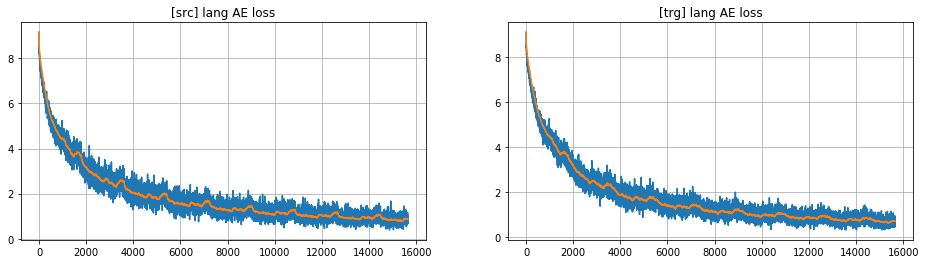

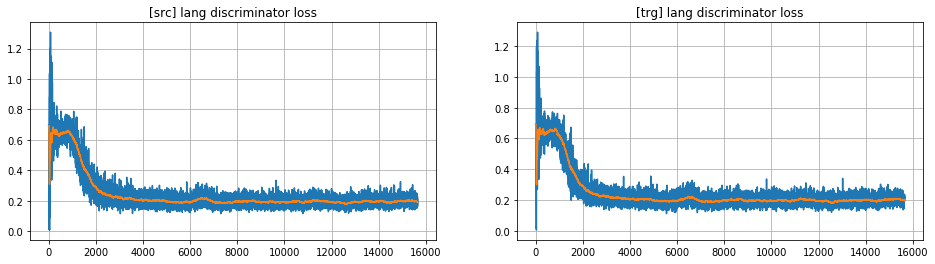

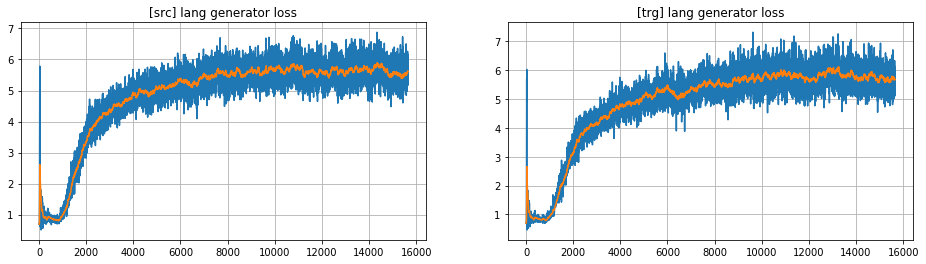

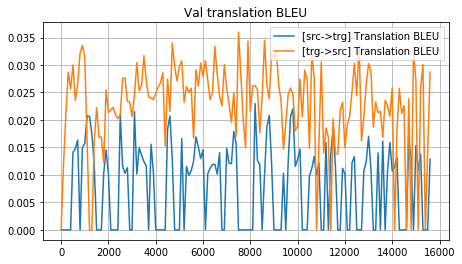

Num iters done: 15678/18130. Current epoch: 8:  65%|██████▍   | 1174/1813 [07:41<04:11,  2.54it/s]


In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam, RMSprop
from tqdm import tqdm
tqdm.monitor_interval = 0

%matplotlib inline

from src.umt_trainer import UMTTrainer
from src.utils.umt_batcher import UMTBatcher
from src.utils.data_utils import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))
adv_criterion = nn.BCELoss()

transformer_optimizer = Adam([
    {'params': transformer.get_trainable_params_without_embs(), 'lr': 1e-4},
    {'params': transformer.get_embs_parameters(), 'lr': 1e-5}
])
# transformer_optimizer = Adam(transformer.get_trainable_parameters(), lr=1e-4)
discriminator_optimizer = Adam(discriminator.parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab_src,
                           vocab_trg, batch_size=16, shuffle=False)
val_data = UMTBatcher(val_src_idx[:100], val_trg_idx[:100], vocab_src,
                      vocab_trg, batch_size=16, shuffle=False)
translation_val_data = Batcher(val_src_idx[:100], val_trg_idx[:100], vocab_src.token2id,
                               vocab_trg.token2id, batch_size=16, shuffle=False)

training_config = {
    'max_num_epochs': 10,
    'start_bt_from_iter': 100000,
    'gen_loss_coef': 0.01
}

trainer = UMTTrainer(transformer, discriminator, vocab_src, vocab_trg,
                  transformer_optimizer, discriminator_optimizer,
                  reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion,
                  training_config)

trainer.run_training(training_data, val_data, translation_val_data, plot_every=50, val_bleu_every=100)